F1 Score: 1.0


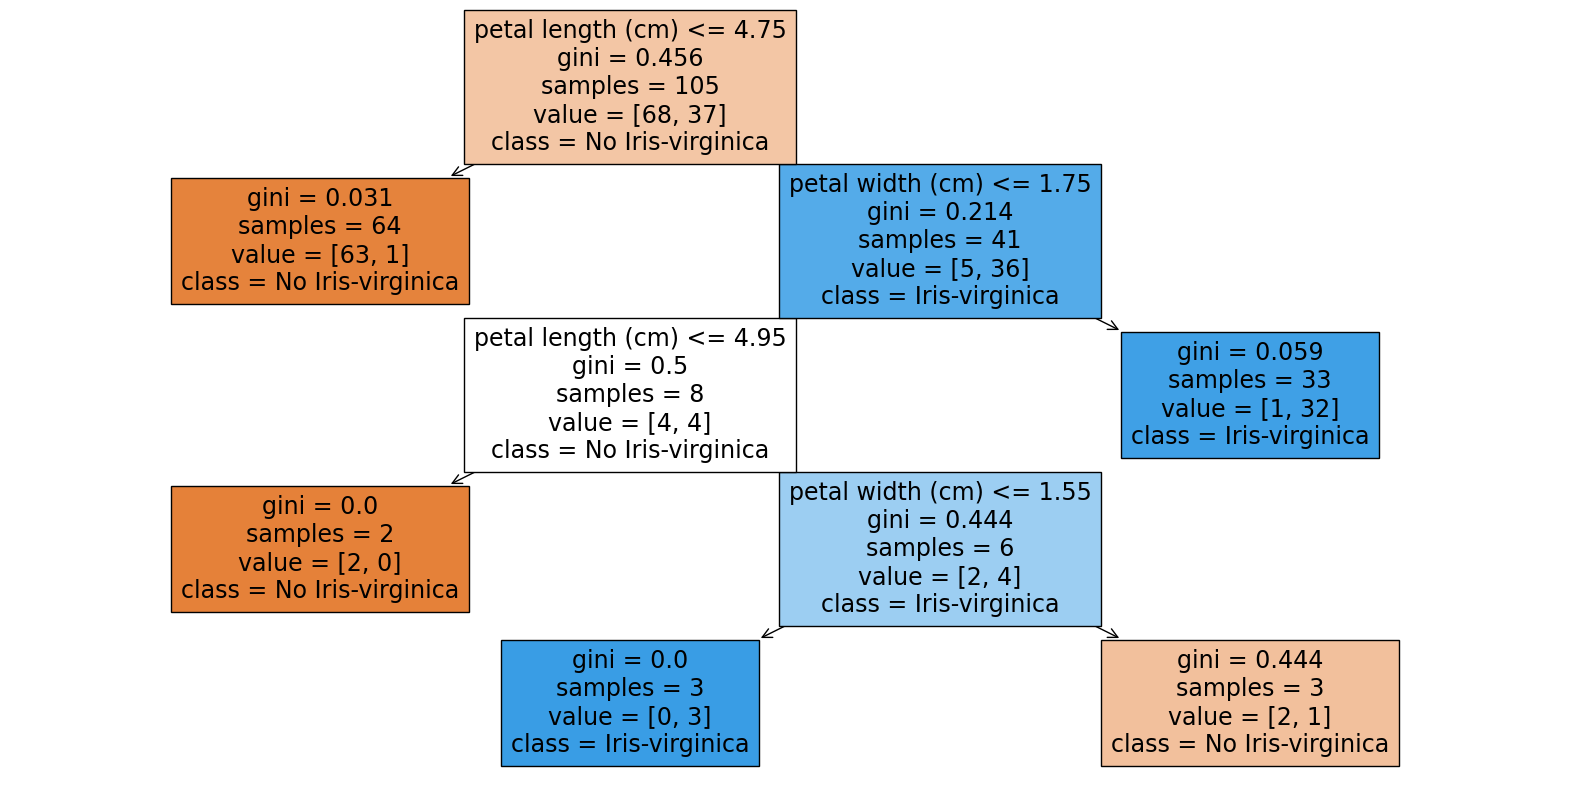

In [1]:
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
import datetime
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import GridSearchCV
from sklearn.tree._tree import TREE_LEAF
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt

def learn_local_decision_tree(Z, Yb, weights, possibles_outcomes, cv=5, poda_tree=False):
    dt = DecisionTreeClassifier()
    if poda_tree:
        param_list = {'min_samples_split': [0.002, 0.01, 0.05, 0.1, 0.2],
                      'min_samples_leaf': [0.001, 0.01, 0.05, 0.1, 0.2],
                      'max_depth': [None, 2, 4, 6, 8, 10, 12, 16]
                      }

        scoring = 'f1'  # Siempre será 'f1' ya que ahora es binario

        dt_search = GridSearchCV(dt, param_grid=param_list, scoring=scoring, cv=cv, n_jobs=-1)
        dt_search.fit(Z, Yb, sample_weight=weights)
        dt = dt_search.best_estimator_
        poda_duplicate_hojas(dt)
    else:
        dt.fit(Z, Yb, sample_weight=weights)

    return dt
def is_leaf(inner_tree, index):
    # Check whether node is leaf node
    return (inner_tree.children_left[index] == TREE_LEAF and
            inner_tree.children_right[index] == TREE_LEAF)


def poda_index(inner_tree, decisions, index=0):

    if not is_leaf(inner_tree, inner_tree.children_left[index]):
        poda_index(inner_tree, decisions, inner_tree.children_left[index])
    if not is_leaf(inner_tree, inner_tree.children_right[index]):
        poda_index(inner_tree, decisions, inner_tree.children_right[index])

    if (is_leaf(inner_tree, inner_tree.children_left[index]) and
        is_leaf(inner_tree, inner_tree.children_right[index]) and
        (decisions[index] == decisions[inner_tree.children_left[index]]) and
        (decisions[index] == decisions[inner_tree.children_right[index]])):
        # turn node into a leaf by "unlinking" its children
        inner_tree.children_left[index] = TREE_LEAF
        inner_tree.children_right[index] = TREE_LEAF
        # print("Pruned {}".format(index))


def poda_duplicate_hojas(dt):
    # Remove leaves if both
    decisions = dt.tree_.value.argmax(axis=2).flatten().tolist()  # Decision for each node
    poda_index(dt.tree_, decisions)

# Resto de las funciones (is_leaf, poda_index, poda_duplicate_hojas) mantienen sin cambios ...

# Cargar el conjunto de datos Iris
data = load_iris()
X = data.data
y = data.target

# Convertir a un problema binario: 1 si es Iris-virginica, 0 en caso contrario
y_bin = [1 if i == 2 else 0 for i in y]

# Dividir el conjunto de datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y_bin, test_size=0.3, random_state=42)

# Definir los posibles resultados (ahora es un problema binario: 0 o 1)
possibles_outcomes = [0, 1]

# Llamar a la función learn_local_decision_tree para entrenar y, posiblemente, podar el árbol de decisión
dt = learn_local_decision_tree(X_train, y_train, weights=None, possibles_outcomes=possibles_outcomes, cv=5, poda_tree=True)

# Evaluar el árbol en el conjunto de prueba
predictions = dt.predict(X_test)

# Imprimir el rendimiento del modelo utilizando el f1_score
print("F1 Score:", f1_score(y_test, predictions))

# Visualizar el árbol
plt.figure(figsize=(20,10))
plot_tree(dt, filled=True, class_names=["No Iris-virginica", "Iris-virginica"], feature_names=data.feature_names)
plt.show()
